### Word2Vec Example
Let's understand how word2vec works in practice using a real dataset. We will use the same dataset (`spooky author identification`) to practice word2vec.

In [1]:
import re
import nltk.data
import warnings
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Any, List, Union
from scipy.sparse.csr import csr_matrix
from time import time

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.cluster import KMeans

from gensim.models import Word2Vec

warnings.filterwarnings('ignore')

In [2]:
# preprocessing functions

def remove_punctuation(text: str) -> str:
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def remove_stopwords(text: str, sw: list) -> str:
    sw = set(sw)
    text = [
        word.lower() for word in text.split() if word.lower() not in sw
    ]
    return " ".join(text)


def remove_numbers(text: str):
    text = [
        re.sub(r'\d+(?:\.\d+)?', '', word) for word in text.split()
    ]
    return " ".join(text)


def stem_text(text: str, stemmer: Any) -> str:
    text = [
        stemmer.stem(word) for word in text.split()
    ]
    return " ".join(text)


def lemmatize_text(text: str, lemmatizer: Any) -> str:
    text = [
        lemmatizer.lemmatize(word) for word in text.split()
    ]
    return " ".join(text)


def get_top_words(vocab: dict, n: int = 10, ascending: bool = False) -> pd.Series:
    """
    Get N top words from word counts (words distribution).

    Parameters
    ----------
    vocab: dict
        Word counts (e.g. {'sunny': 10, 'big': 23}).
    n: int
        Number of words to show (e.g. 10 -> top 10).
    ascending: bool
        If True, show in ascending order.

    Returns
    -------
    pd.DataFrame
        Word counts.

    """
    if ascending:
        result = pd.Series(vocab).sort_values()
    else:
        result = pd.Series(vocab).sort_values(ascending=False)
    return result.iloc[:n]


def get_pd_fm(sparce_matrix: csr_matrix, vectorizer: Any) -> pd.DataFrame:
    """
    Transforms Sparse CSR matrix into Pandas dense with feature names in columns.

    Parameters
    ----------
    sparce_matrix
        Sparce matrix of features.
    vectorizer: Any
        Used vectorizer for features generation (e.g. 'CountVectorizer', ...).
    
    Returns
    -------
    pd.DataFrame
        Pandas dense matrix of features.
    """
    return pd.DataFrame(
        data=sparce_matrix.todense(),
        columns=vectorizer.vocabulary_.keys()
    )

In [3]:
def preprocess_text(
    text: str,
    stop_words: List[str],
    normalizer: Any
) -> str:
    """Basic preprocessing for text."""
    # preprocessing
    clean_text = remove_punctuation(text)
    clean_text = remove_numbers(clean_text)
    clean_text = remove_stopwords(clean_text, stop_words)

    # text normalization
    if re.search(r'.*stemmer', type(normalizer).__name__,  re.IGNORECASE):
        clean_text = stem_text(clean_text, normalizer)
    
    if re.search(r'.*lemma', type(normalizer).__name__,  re.IGNORECASE):
        clean_text = lemmatize_text(clean_text, normalizer)

    return clean_text

### Data Downloading

In [4]:
data = pd.read_csv(r'../../data/spooky-author-identification/train.csv')
print('Data Shape: ', data.shape[0])

data.head()

Data Shape:  19579


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


**Important**
- `Word2Vec` model **expects single sentences for training** Thus, we need to create sentences from each document.
- Sentence splitting **might be tricky** because it's not always clear if a sentence indeed ended. However, we can use set of hard rules (e.g. `.`, `!`, ...)
    - For easier sentences splitting use `NLTK's punkt tokenizer`
    - Main logic: `Document -> Sentence Splitter -> Sentences -> Preprocess Each Sentence -> Sentence Tokens` 
    - Obviously `n_sentences` > `n_documents` (might be also equal but rarely)
- **Not only words** can be encoded but n_grams as well

### Data Preprocessing

In [5]:
def text_to_sentences(text: str) -> List[str]:
    """
    Converts text into a list of sentences using nltk punkt tokenizer.
    """
    import nltk.data

    # Load the punkt tokenizer
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    return tokenizer.tokenize(text.strip())

In [6]:
# sentences example
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

example_sentence = 'I am doing fine. How are you? Good Thanks!'
raw_sentences = tokenizer.tokenize(example_sentence.strip())
raw_sentences

['I am doing fine.', 'How are you?', 'Good Thanks!']

- Each token represents a sentence

In [7]:
# preprocess sentences/tokens
stop_words = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

clean_sentences = [
    word_tokenize(
        preprocess_text(text=sentence, stop_words=stop_words, normalizer=lemmatizer)
    )
    for sentence in raw_sentences
]

clean_sentences

[['fine'], [], ['good', 'thanks']]

In [8]:
# put all together
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

# get sentences
raw_sentences = [
    tokenizer.tokenize(sentence.strip()) for sentence in data['text']
]
print('Sentences Splitting Done!')

# preprocess sentences and get tokens
clean_sentences = [
    word_tokenize(
        preprocess_text(text=sentence[0], stop_words=stop_words, normalizer=lemmatizer)
    )
    for sentence in raw_sentences
]
print('Sentences Tokenization Done!')

Sentences Splitting Done!
Sentences Tokenization Done!


In [9]:
"""
After applying NLTK punkt tokenizer our sentences belong to the same list but are split using comma
For example, 'I am doing fine. How are you? Good Thanks!' -> ['I am doing fine.', 'How are you?', 'Good Thanks!']

Thuse, we need to get len of lists, not the number of lists because we will get this: n_documents == n_sentences
"""
n_sentences = sum(list(map(len, raw_sentences)))

print('N Unique Texts: ', data['text'].shape[0])
print('N Unique Sentences: ', n_sentences)

N Unique Texts:  19579
N Unique Sentences:  20210


**Interpretation**
- We have a bit higher number of sentences than original documents -> Most of the documents have single sentences

In [10]:
# have a look at sentences distribution for a text
sentences_distr = data['text'].apply(lambda x: len(text_to_sentences(x))).sort_values(ascending=False)
sentences_distr

15054    9
3759     6
18466    6
12340    6
10206    5
        ..
6611     1
6610     1
6609     1
6608     1
19578    1
Name: text, Length: 19579, dtype: int64

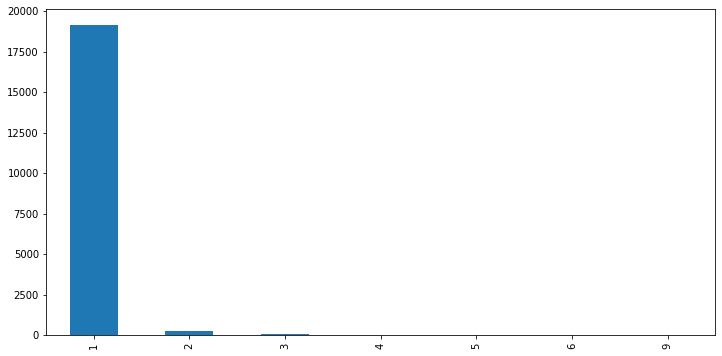

In [11]:
plt.figure(figsize=(12, 6))
sentences_distr.value_counts().plot(kind='bar');

**Interpretation**
- Most texts have single sentence 

In [12]:
_sentences_distr = sentences_distr.value_counts()

print('N Text Unique (Single Sentence): ', _sentences_distr[1])
print('N Text Unique (> 2 Sentences): ', _sentences_distr[2:].sum())

N Text Unique (Single Sentence):  19160
N Text Unique (> 2 Sentences):  146


**Interpretation**
- We don't have many texts that have more than 1 sentece (0.7%) -> we can exclude such texts or only leave texts that have the following sentence length (3, 4)


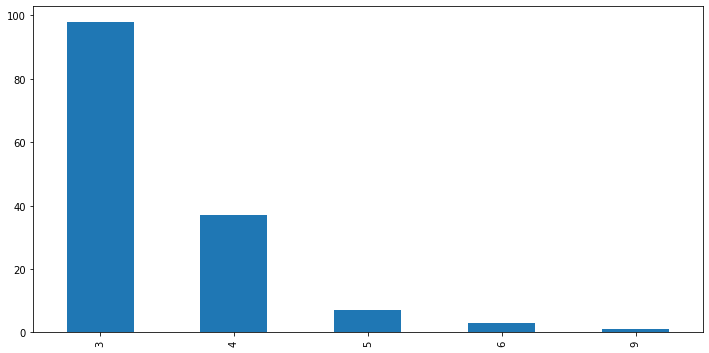

In [13]:
plt.figure(figsize=(12, 6))
_sentences_distr = sentences_distr.value_counts()
_sentences_distr[2:].plot(kind='bar');

In [14]:
# leave only single sentence texts
text_data = data[data.index.isin(sentences_distr[sentences_distr == 1].index)]
text_data

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


In [15]:
# preprocess again
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

# get sentences
raw_sentences = [
    tokenizer.tokenize(sentence.strip()) for sentence in text_data['text']
]
print('Sentences Splitting Done!')

# preprocess sentences and get tokens
clean_sentences = [
    word_tokenize(
        preprocess_text(text=sentence[0], stop_words=stop_words, normalizer=lemmatizer)
    )
    for sentence in raw_sentences
]
print('Sentences Tokenization Done!')

Sentences Splitting Done!
Sentences Tokenization Done!


### Gensim Parameters
- `Architecture`: 
    - Architecture options are skip-gram (default) or continuous bag of words.
- `Training algorithm`:
    - Hierarchical softmax (default) or negative sampling.
- `Downsampling of frequent words (sample)`:
    - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial (.001 - .00001)
- `Word Vector Dimensionality (size)`: 
    - Embeddings vectors dimensionality size (50, 300)
- `Context / Window Size (window)`: 
    - How many words of context should the training algorithm take into account? (2, 10)
- `Minimum Word Count (min_count)`: 
    - This helps limit the size of the vocabulary to meaningful words. Ignores all words with total absolute frequency lower than this (10-100)
- `Learning Rate (alpha)`
    - Neural Net learning rate (0.01, 0.05)
- `Learning Rate Decrease (min_alpha)`
    - Learning rate will linearly drop to `min_alpha` as training progresses
- `Negative Sampling (negative)`
    - If > 0, negative sampling will be used, specifies how many "noise words" should be drown. (5, 20)

In [16]:
# word2vec parameters
num_workers = 4 
embedding_dim = 300
min_word_count = 40 
context_window_size = 10
downsampling = 1e-3        

w2v_model = Word2Vec(
    workers=num_workers,
    size=embedding_dim,
    min_count=min_word_count,
    window=context_window_size,
    sample=downsampling
)

**Building Vocabulary Table**
- `Word2Vec` requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them)

In [17]:
t = time()

w2v_model.build_vocab(clean_sentences, progress_per=10_000)

print('Time to build Vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build Vocab: 0.01 mins


### Model Training

In [18]:
t = time()

w2v_model.train(
    clean_sentences,
    total_examples=w2v_model.corpus_count,
    epochs=30,
    report_delay=1
)

print('Time Taken: {} mins'.format(round((time() - t) / 60, 2)))

Time Taken: 0.09 mins


In [19]:
# makes model more memory-efficient
w2v_model.init_sims(replace=True)

### Model Methods

**Get Model Vocabulary and Embeddings**

In [20]:
def get_w2v_embeddings(model: Any) -> dict:
    """Get dict of tokens their embeddings."""
    model_vocab = w2v_model.wv.vocab
    return {word: model.wv[word] for word in model_vocab}


def sample_from_model_vocab(
    model: Any, n_samles: int = 10, random_state: int = 23
) -> List[str]:
    """Sample N random words from model vocab."""
    model_vocab = pd.Series(w2v_model.wv.vocab.keys())
    return model_vocab.sample(n_samles, random_state=random_state).tolist()


word_embeddings = get_w2v_embeddings(w2v_model)

In [21]:
# get vocab
n_samles = 10
words_sample = sample_from_model_vocab(w2v_model, n_samles, random_state=None)
words_sample

['could',
 'frequent',
 'gazed',
 'hour',
 'arm',
 'grey',
 'ordinary',
 'feeling',
 'aid',
 'horse']

In [22]:
# another way of getting model vocabulary
model_vocab = w2v_model.wv.index2word
model_vocab[:5]

['one', 'upon', 'could', 'would', 'time']

In [23]:
# embeddings
word_embeddings['run'][:10] # first 10 embedding values

array([-6.7611807e-03,  1.5516772e-02,  6.0099427e-02,  1.6541122e-05,
       -4.4299230e-02, -3.7883122e-02, -1.6129525e-02, -2.5902890e-02,
        1.0306043e-01, -6.7690209e-02], dtype=float32)

**How to Get Most Similar Embedding?**
- `Metric`: cosine similarity

In [24]:
# single word example (find the most similar vector to a given one)
w2v_model.wv.most_similar(positive=["perdita"], topn=5)

[('adrian', 0.8462410569190979),
 ('raymond', 0.7869153022766113),
 ('idris', 0.7616019248962402),
 ('lord', 0.7060190439224243),
 ('windsor', 0.6993862986564636)]

In [25]:
w2v_model.wv.most_similar(positive=["england", "rain"], negative=['english'],  topn=5)

[('winter', 0.7941612005233765),
 ('summer', 0.7110149264335632),
 ('spring', 0.690467119216919),
 ('fled', 0.6837972402572632),
 ('storm', 0.6812300086021423)]

**Hot to Measure Similarity between Vectors?**

In [26]:
sim_a = w2v_model.wv.similarity(w1='england', w2='lake')
sim_b = w2v_model.wv.similarity(w1='england', w2='english')

print('Sim A: ', sim_a)
print('Sim B: ', sim_b)

Sim A:  0.16550495
Sim B:  0.37606353


**How to Identify Unmatching Words in a Sequence?**

In [27]:
w2v_model.wv.doesnt_match(['england', 'english', 'lake'])

'lake'

**How to Save/Load Embeddings?**

In [28]:
# model_name = "spooky_author_embeddings"
# w2v_model.save(model_name)
# w2v_model = Word2Vec.load(model_name)

### Embeddings Visualization
To visualize embeddings we can use the following techniques:
- t-sne
- UMAP
- PCA

PCA is a linear (better skip) method whereas t-sne and UMAP are non-linear. 



In [29]:
import numpy as np
from sklearn.manifold import TSNE

def visualize_word_embeddings(
    model: Any,
    method: Any,
    word: str,
    word_list: List[str] = None,
    n_similar: int = 0,
    n_random: int = 0,
    random_state: int = 23
):
    """
    Visualizes an embeddings of a target word in comparison with top_n closests and random words.
    """
    # for colorful plotting
    colors = ['red']
    labels = [word]

    embeddings = w2v_model.wv[word].reshape(1, -1)
    similar_words = model.wv.most_similar([word], topn=n_similar)
    random_words = sample_from_model_vocab(model, n_random, random_state)
    
    # add most similar words to 'embeddings' 
    for word in similar_words:
        word_embedding = w2v_model.wv[word[0]].reshape(1, -1)
        embeddings = np.vstack((embeddings, word_embedding))

        colors.append('green')
        labels.append(word[0])

    if n_random > 0:
        # add random words to 'embeddings'
        for word in random_words:
            word_embedding = w2v_model.wv[word].reshape(1, -1)
            embeddings = np.vstack((embeddings, word_embedding))

            colors.append('blue')
            labels.append(word)

    if word_list:
        for word in word_list:
            word_embedding = w2v_model.wv[word].reshape(1, -1)
            embeddings = np.vstack((embeddings, word_embedding))

            colors.append('blue')
            labels.append(word)

    reduced_vectors = method.fit_transform(embeddings)

    plot_df = pd.DataFrame({
        'x': [x for x in reduced_vectors[:, 0]],
        'y': [y for y in reduced_vectors[:, 1]],
        'words': labels,
        'color': colors
    })
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # main plot
    p1 = sns.regplot(
        data=plot_df, x="x", y="y",
        fit_reg=False, marker="o",
        scatter_kws={'s': 40, 'facecolors': plot_df['color']}
    )
    
    # plot annotation
    for line in range(0, plot_df.shape[0]):
        p1.text(
            plot_df["x"][line],
            plot_df['y'][line],
            plot_df["words"][line],
            horizontalalignment='left',
            verticalalignment='bottom', size='medium',
            color=plot_df['color'][line],
            weight='normal'
        ).set_size(15)

    plt.xlim(reduced_vectors[:, 0].min()-50, reduced_vectors[:, 0].max()+50)
    plt.ylim(reduced_vectors[:, 1].min()-50, reduced_vectors[:, 1].max()+50)

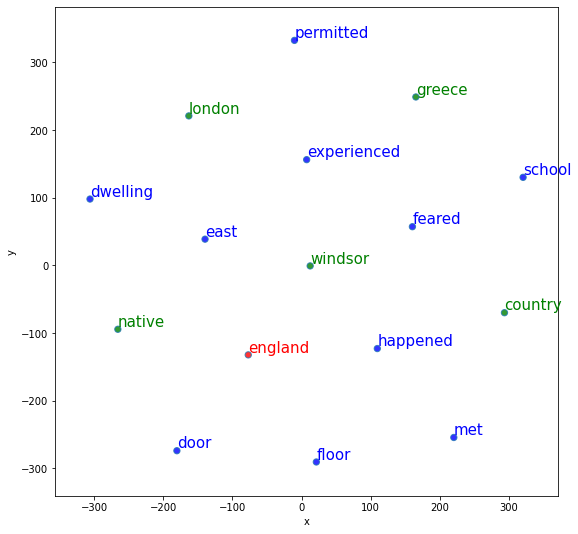

In [30]:
visualize_word_embeddings(
    model=w2v_model,
    method=TSNE(n_components=2, random_state=0, perplexity=15),
    word='england',
    n_similar=5,
    n_random=10,
    random_state=None
)

### Embeddings Averaging
Embeddings averaging allows getting embedding of a "higher entity". For example, word embeddings are part of sentences and thus average of a sentence embedding provides embedding of a sentence. Then sentence embeddings can be averaged as well to get document embeddings. 
This procedure can be done several times depening on what embedding level we would like to get in the end (e.g. sentence, document, document collection, etc.)

In [31]:
def get_sentence_embedding(model: Any, sentence: List[str], average=True) -> np.ndarray:
    """
    Gets embeddings of a sentence. If 'average' True, returns sentence embedding (everaged tokens embeddings)

    Sentence Embeddings have the following structure:
    [
        [a, b, c, ...], # token_a embedding
        [e, f, g, ...], # token_b embedding 
        ...
    ]

    Sentence Embedding (after averaging):
    [x, y, z, ...]
    """
    random_word= sample_from_model_vocab(model, n_samles=1, random_state=23) # to get word embedding dim
    embeddings_dim = model.wv[random_word].reshape(1, -1).shape[1]
    model_vocab = set(model.wv.index2word) # set to process faster

    sentence_embeddings = np.zeros((1, embeddings_dim),dtype="float32") # pre-initialize an empty numpy array to store sentence embeddings

    # iterate over tokens in a sentence to get embeddings
    for word in sentence:
        if word in model_vocab: # not all tokens will have embeddings after model training!
            word_embedding = model.wv[word].reshape(1, -1)
            sentence_embeddings = np.vstack((sentence_embeddings, word_embedding))

    if average:
        return np.mean(sentence_embeddings[1:, :], axis=0) # average embeddings of a sentence by skipping zero vector
    
    return sentence_embeddings[1:, :]


# def get_document_embedding(model: Any, sentences: List[List[str]], average: bool = True):
#     for sentence in sentences:
#         get_sentence_embedding(model: Any, sentence: List[str], average=True)


In [32]:
# test the function
sentence_embeddings = get_sentence_embedding(model=w2v_model, sentence=clean_sentences[0], average=False)
sentence_embedding = get_sentence_embedding(model=w2v_model, sentence=clean_sentences[0], average=True) # may be worth reshaping .reshape(1, -1)

In [33]:
# obtained shapes
sentence_embeddings.shape, sentence_embedding.shape

((12, 300), (300,))

In [34]:
# get sentences embeddings, since each document consists of a single sentence -> get document embeddings
document_embeddings = [
    get_sentence_embedding(model=w2v_model, sentence=sentence, average=True)
    for sentence in clean_sentences
]

print('N Unique Document Embeddings: ', len(document_embeddings))

N Unique Document Embeddings:  19160


**Visualize Averaged Embeddings**

Let's do simialr task that we've done for **word embeddings** but this time for **document embeddings** to see what documents are the most similar for a given one. Each document has its own id that we can use to distinguish between documents.

In [35]:
# document embeddings
doc_embeddings = dict(zip(text_data['id'], document_embeddings))

# author embeddings
author_embeddings = pd.DataFrame({
    'author': text_data['author'],
    'doc_id': text_data['id'],
    'doc_embedding': document_embeddings
})

author_embeddings

,author,doc_id,doc_embedding
0,EAP,id26305,"[0.020601247, 0.000815552, 0.011412996, 0.0103..."
1,HPL,id17569,"[-0.009243343, -0.018183956, -0.0034470204, 0...."
2,EAP,id11008,"[0.00012538086, 0.0043259845, 0.021571979, 0.0..."
3,MWS,id27763,"[0.048537422, 0.024219256, 0.0016514007, 0.002..."
4,HPL,id12958,"[-0.027343541, -0.03192165, -0.008161303, 0.01..."
...,...,...,...
19574,EAP,id17718,"[0.013075388, 0.00959399, -0.023849744, 0.0044..."
19575,EAP,id08973,"[0.021230375, -0.10860281, 0.039143827, -0.091..."
19576,EAP,id05267,"[-0.013748157, -0.013499972, -0.017352063, -0...."
19577,EAP,id17513,"[0.032380674, -0.05636816, 0.022816116, -0.019..."


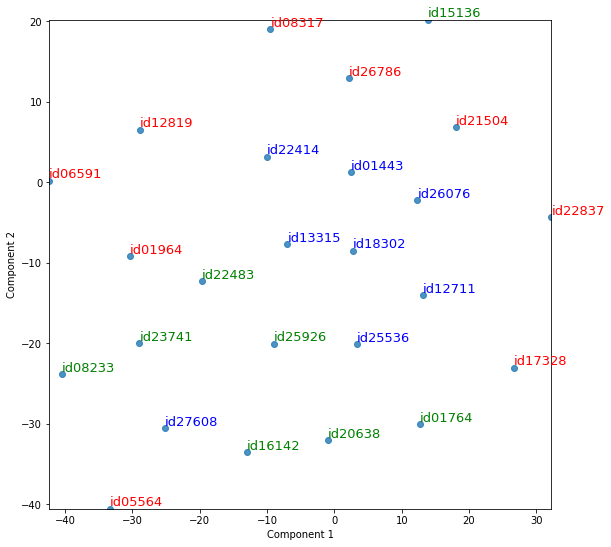

In [37]:
# plot t-SNE visualization of random subsample
n_samples = 25
sample_df = author_embeddings.sample(n_samples)
sample_df['color'] = sample_df['author'].map(
    {'EAP': 'green', 'MWS': 'red', 'HPL': 'blue'}
) # for plotting

stacked_vectors = np.stack(sample_df['doc_embedding'])
tsne = TSNE(n_components=2, random_state=0, perplexity=15)
reduced_vectors = tsne.fit_transform(stacked_vectors)

fig, ax = plt.subplots(figsize=(18, 8))
fig.set_size_inches(9, 9)

# plot
p1 = sns.regplot(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    fit_reg=False, marker="o",
    ax=ax
)

# annotation
for i in range(0, sample_df.shape[0]):
    ax.text(
        reduced_vectors[i, 0],
        reduced_vectors[i, 1],
        sample_df["doc_id"].iloc[i],
        color=sample_df['color'].iloc[i],
        horizontalalignment='left',
        verticalalignment='bottom',
        size='medium',
        weight='normal'
    ).set_size(13)

ax.set_xlim([min(reduced_vectors[:, 0]), max(reduced_vectors[:, 0])])
ax.set_ylim([min(reduced_vectors[:, 1]), max(reduced_vectors[:, 1])])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.show()

**Interpretation**
- We see how different some documents in a vector space
- Some documents are more similar to the documents from another author (written about the same but by different authors)
- Let's compare text using the plot above in terms of similarity (may be not ideal)

In [38]:
ids = [
    'id01145',
    'id23849',
    'id12446',
    'id26433'
]

for text_id in ids:
    doc = text_data[text_data['id'] == text_id]['text'].iloc[0]
    print('\n', text_id)
    print(doc)


 id01145
Despite weakness, hunger, horror, and bewilderment I found myself after a long time able to walk; so started slowly along the muddy road to Rowley.

 id23849
March d the crew of the Emma landed on an unknown island and left six men dead; and on that date the dreams of sensitive men assumed a heightened vividness and darkened with dread of a giant monster's malign pursuit, whilst an architect had gone mad and a sculptor had lapsed suddenly into delirium And what of this storm of April nd the date on which all dreams of the dank city ceased, and Wilcox emerged unharmed from the bondage of strange fever?

 id12446
The door of the cathedral stood invitingly open.

 id26433
Bankers, merchants, and manufacturers, whose trade depended on exports and interchange of wealth, became bankrupt.


**Important**
- Some embeddings may contain NaN values that may lead to NaN vectors after averaging. Thus, use `np.nanmean` or `np.nan_to_num`

In [39]:
# preprocess embeddings (NaN)
author_embeddings['doc_embedding'] = author_embeddings['doc_embedding'].apply(lambda x: np.nan_to_num(x))

# everage embeddings
_author_embeddings = {}
for author in author_embeddings['author'].unique():
    stacked_array = np.stack(author_embeddings[author_embeddings['author'] == author]['doc_embedding'])
    _author_embeddings[author] = np.mean(stacked_array, axis=0)

_author_embeddings = pd.DataFrame({
    'author': _author_embeddings.keys(),
    'embedding': _author_embeddings.values()
})

_author_embeddings

,author,embedding
0,EAP,"[0.007467883, -0.0131926965, -0.0018916201, -0..."
1,HPL,"[0.0041857837, -0.004327952, -0.021617154, -0...."
2,MWS,"[0.009015861, -0.0069331313, -0.009206791, -0...."


In [40]:
vec_a = _author_embeddings[_author_embeddings['author'] == 'EAP']['embedding'].iloc[0]
vec_b = _author_embeddings[_author_embeddings['author'] == 'HPL']['embedding'].iloc[0]
vec_c = _author_embeddings[_author_embeddings['author'] == 'MWS']['embedding'].iloc[0]

In [41]:
from scipy.spatial.distance import cosine

a_b_sim = 1 - cosine(vec_a, vec_b)
a_c_sim = 1 - cosine(vec_a, vec_c)
b_c_sim = 1 - cosine(vec_b, vec_c)

print(a_b_sim)
print(a_c_sim)
print(b_c_sim)

0.5108882188796997
0.40170368552207947
0.3221212327480316


### Embeddings Clustering
Word2Vec creates clusters of semantically related words, thus, we can cluster embeddings. Any clustering algorthm can be applied. Besides, we can reduce embeddings dimensionality before applying clustering.

**Words Clustering**

In [114]:
_word_embeddings = w2v_model.wv.vectors
print('Vocab Size: ', _word_embeddings.shape[0])

Vocab Size:  1222


In [115]:
%%time

num_clusters = len(model_vocab) // 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_indx = kmeans.fit_predict(_word_embeddings)

Wall time: 6.38 s


In [116]:
# get cluster info 
cluster_dist = np.unique(cluster_indx, return_counts=True)

cluster_summary = pd.Series(
    data=cluster_dist[1],
    index=cluster_dist[0]
).sort_values(ascending=False)

cluster_summary

13     19
49     14
61     14
201    14
98     13
       ..
209     1
101     1
212     1
215     1
115     1
Length: 244, dtype: int64

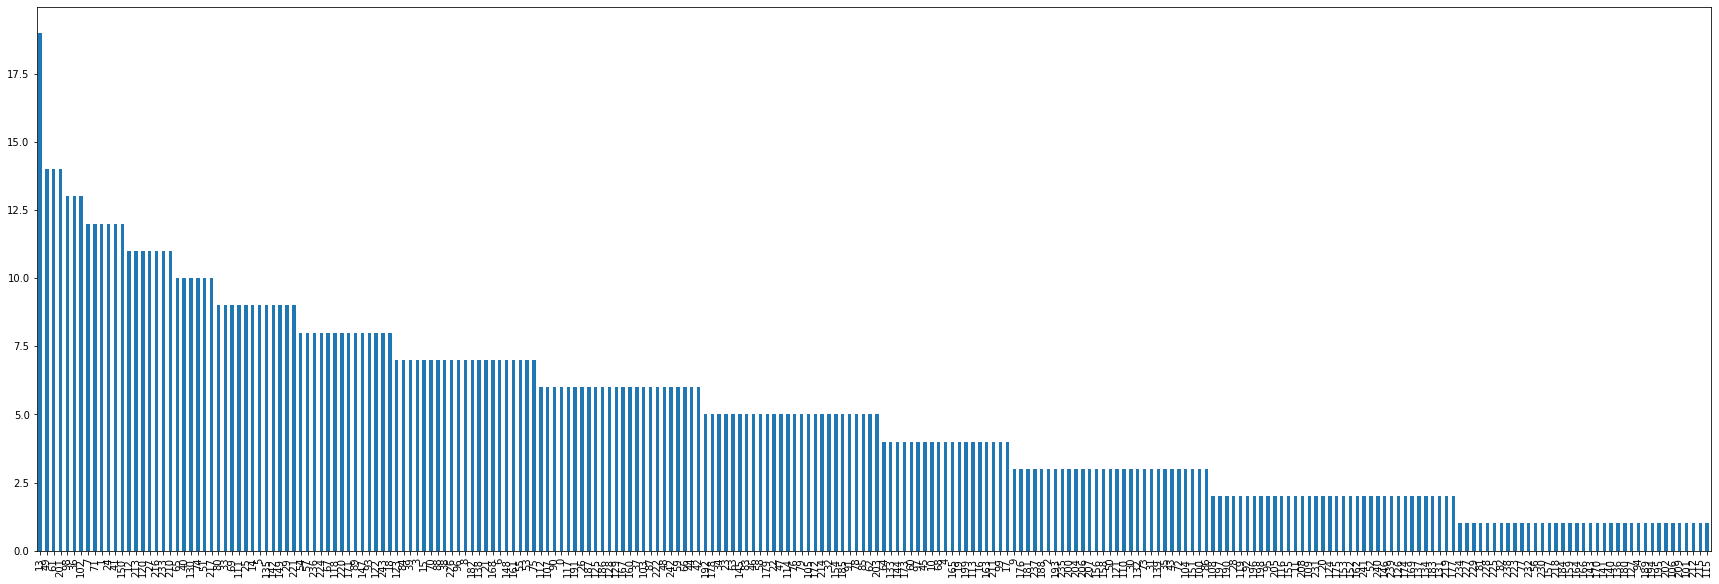

In [117]:
plt.figure(figsize=(30, 10))
cluster_summary.plot(kind='bar')
plt.show()

In [118]:
# look at top N clusters 
n = 5
selected_clusters = cluster_summary.index[:n].tolist()
selected_clusters

[13, 49, 61, 201, 98]

In [126]:
# look at words in the clusters
for cluster_id in selected_clusters:
    words_array = np.array(w2v_model.wv.index2word)
    mask = cluster_indx == cluster_id
    print(f'\nCluster {cluster_id}')
    print('\n', words_array[mask])



Cluster 13

 ['like' 'around' 'black' 'stood' 'white' 'green' 'heavy' 'red' 'covered'
 'huge' 'grey' 'tall' 'slowly' 'thin' 'big' 'thick' 'yellow' 'bearing'
 'silver']

Cluster 49

 ['two' 'three' 'nearly' 'minute' 'five' 'four' 'six' 'twenty' 'ten'
 'hundred' 'inch' 'eight' 'fifty' 'thirty']

Cluster 61

 ['heart' 'soul' 'despair' 'mine' 'grief' 'frame' 'agony' 'fearful'
 'emotion' 'struggle' 'bosom' 'bitter' 'mortal' 'anguish']

Cluster 201

 ['rather' 'mere' 'natural' 'principle' 'extent' 'considered' 'sole'
 'possession' 'perfect' 'science' 'conclusion' 'theory' 'difficult'
 'intellect']

Cluster 98

 ['beneath' 'vast' 'distance' 'visible' 'top' 'clear' 'bottom' 'edge'
 'horizon' 'gigantic' 'summit' 'mass' 'centre']


- Performance is not ideal but some clusters more or less good (e.g. 49)
- The same idea can be applied on embeddings of other dimension (e.g. sentences, documents, ...)

**Important**
- Obtained centroids from clustering can be used as features for the model or other tasks (i.e. from BoW to Bag of Centroids). In this case instead of using embeddings we use centrods coordinates as features for each word
- The main drawback of using clustering and averaging word vectors -> **we loose word order that is important**
- The best way to imporve performance of word vectors -> train them on huge dataset (lots of texts). Better use pre-trained models!

In [144]:
def word2centroid(word, algorithm,  word_array, clusters):
    word_index = np.where(words_array == word)
    cluster_id = clusters[word_index]
    return kmeans.cluster_centers_[cluster_id]


word_centroid = word2centroid(
    word='despair',
    algorithm=kmeans,
    word_array=words_array,
    clusters=cluster_indx
)

### Resources
- https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-3-more-fun-with-word-vectors
- https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial#Preprocessing